# Airbnb Seattle Dataset Analysis

In [584]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline
pd.set_option("max_columns", None)
sns.set_palette(sns.color_palette("colorblind"))

In [674]:
# read in data
listings = pd.read_csv('./data/listings.csv')
calendar = pd.read_csv('./data/calendar.csv')

In [675]:
# Note number of columns
before = len(listings.columns)

# Drop columns with all null values
all_null = len(listings.columns[listings.isnull().mean() == 1])
listings = listings.dropna(how='all', axis=1)

# Drop columns with more than 50% null values
more_than_50_null = listings.columns[listings.isnull().mean() > 0.5]
listings = listings.drop(more_than_50_null, axis=1)

# Drop columns with only one value
one_value_columns = [
    column for column in listings.columns if len(listings[column].unique()) == 1
]
listings.drop(one_value_columns, axis=1, inplace=True)

# Drop url, ID (except for 'id') and name columns
url_id_columns = listings.columns[listings.columns.str.contains('url|_id|name')]
listings = listings.drop(url_id_columns, axis=1)

print(
    '{} columns dropped:\
    \n\t{} columns with only null values\
    \n\t{} columns with more than 50% null values\
    \n\t{} columns with only one unique value\
    \n\t{} URL/ID/name columns'.format(
        before - len(listings.columns), all_null, len(more_than_50_null),
        len(one_value_columns), len(url_id_columns)
    )
)

26 columns dropped:    
	1 columns with only null values    
	3 columns with more than 50% null values    
	10 columns with only one unique value    
	12 URL/ID/name columns


Now we will drop additional features from the dataset for various reasons:
- they're covered by other features
- they're adding noise (variance) in beeing coliniear to our target variable (price)
- they feature almost completly one single value

In [676]:
to_drop = [
    'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
    'host_verifications', 'host_has_profile_pic', 'street', 'neighbourhood',
    'city', 'zipcode', 'smart_location', 'latitude', 'longitude',
    'is_location_exact', 'cleaning_fee', 'guests_included', 'extra_people',
    'minimum_nights', 'maximum_nights', 'calendar_updated', 'availability_30',
    'bed_type', 'availability_60', 'availability_90', 'availability_365',
    'first_review', 'last_review', 'review_scores_rating', 
    'review_scores_accuracy', 'review_scores_cleanliness', 
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'require_guest_profile_picture', 
    'require_guest_phone_verification', 'weekly_price', 'neighbourhood_cleansed'
]

listings = listings.drop(to_drop, axis=1)

In [677]:
# remove plain text features
description_features = ['summary', 'space', 'description', 'notes', 'neighborhood_overview', 'transit', 'host_about']
listings = listings.drop(description_features, axis =1)

# Convert host_since to datetime and create host_since_days timedelta feature
listings.host_since = pd.to_datetime(listings.host_since, yearfirst=True)
listings['host_since_days'] = (listings.host_since - listings.host_since.min()).dt.days

# Create is_local feature based on host_location
local_destination = 'Seattle, Washington, United States'
listings['is_local_host'] = listings.host_location.apply(
    lambda location: 1 if location==local_destination else 0
)

# Map host_response_time values to numerical values
response_map = {
    np.nan: 0,
    'a few days or more': 1,
    'within a day': 2,
    'within a few hours': 3,
    'within an hour': 4
}
listings.host_response_time = listings.host_response_time.replace(response_map)

# Drop converted features
listings = listings.drop(['host_since', 'host_location'], axis=1)

# strip "$", "%", "," characters from percentage & price columns
for column in ['host_response_rate', 'host_acceptance_rate', 'price']:
    listings[column] = listings[column].apply(lambda value: re.sub(r'\$|,|%', '', str(value))).astype(float)

# Convert boolean t/f columns to 1/0 columns
for column in ['host_is_superhost', 'instant_bookable']:
    listings[column] = listings[column].apply(lambda val: True if val=='t' else False)

In order to train our model on somewhat successful hosts we will filter the dataset for listings that already have reviews. This has the handy side effect, that we get rid of some outliers too.

In [678]:
num_without_reviews = listings[listings.number_of_reviews==0].shape[0]
percent_gone = num_without_reviews / listings.shape[0]

print(f'{num_without_reviews} rows or {percent_gone:.2%} of rows dropped as having no reviews')

listings = listings[listings.number_of_reviews!=0]

627 rows or 16.42% of rows dropped as having no reviews


In [679]:
# Drop any rows without the predictor value
calendar.dropna(subset=['price'], inplace=True)

# Convert price into a float
calendar.price = calendar.price.apply(
    lambda value: re.sub(r'\$|,', '', value)
).astype(float)

# Extract month from date string and rewrite values
calendar.date = pd.to_datetime(calendar.date)
calendar['month'] = calendar.date.apply(lambda value: value.month)

# Drop available and date columns
calendar = calendar.drop(['available', 'date'], axis=1)

In [680]:
translation_table = dict.fromkeys(map(ord, '{"}'), None)

amenities_lists = listings.amenities.apply(lambda raw_string: raw_string.translate(translation_table).split(','))
amns_df = pd.get_dummies(amenities_lists.apply(pd.Series).stack(), drop_first=True).groupby(level=0).sum()

# recode 'Washer / Dryer' column to avoid additonal noise
amns_df['Washer / Dryer'] = np.where((amns_df.Washer == 1) | (amns_df.Dryer == 1), 1, amns_df["Washer / Dryer"])
# recode 'TV' column to avoid additonal noise
amns_df['TV'] = np.where((amns_df['Cable TV'] == 1), 1, amns_df["TV"])
# assign 'Internet' = True where 'Wireless Internet' is available
amns_df.Internet = np.where(amns_df['Wireless Internet'] == 1, 1, amns_df.Internet)
# assign 'Pets Allowed' =1 to all rows with cats/dogs/other pets == 1 and drop these rows
amns_df['Pets Allowed'] = np.where((amns_df['Cat(s)']==1) | (amns_df['Dog(s)']==1) | (amns_df['Other pet(s)']==1), 1, amns_df['Pets Allowed'])
# combine "Pool", "Gym", "Hottub" columns
amns_df['Pool/Gym/Hot Tub'] = np.where((amns_df['Pool']==1) | (amns_df['Hot Tub']==1), 1, amns_df['Gym'])
# remove now obsolete columns
amns_df.drop(['Cat(s)', 'Dog(s)', 'Other pet(s)', "Wireless Internet", "Washer", "Dryer", "Cable TV", "Pool", "Gym", "Hot Tub"], axis=1, inplace=True)

In [681]:
amns_df.describe()

,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Carbon Monoxide Detector,Doorman,Elevator in Building,Essentials,Family/Kid Friendly,Fire Extinguisher,First Aid Kit,Free Parking on Premises,Hair Dryer,Hangers,Heating,Indoor Fireplace,Internet,Iron,Kitchen,Laptop Friendly Workspace,Lock on Bedroom Door,Pets Allowed,Pets live on this property,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer / Dryer,Wheelchair Accessible,Pool/Gym/Hot Tub
count,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000,3191.000000
mean,0.144155,0.176747,0.078032,0.143529,0.664995,0.021310,0.204325,0.858352,0.526794,0.582576,0.451896,0.578502,0.189596,0.198997,0.959574,0.232529,0.975870,0.182075,0.902225,0.171420,0.016609,0.298339,0.237543,0.195550,0.719524,0.871200,0.021623,0.058289,0.719210,0.790661,0.079912,0.152930
std,0.351302,0.381514,0.268264,0.350666,0.472066,0.144438,0.403270,0.348744,0.499360,0.493211,0.497759,0.493876,0.392043,0.399308,0.196988,0.422511,0.153478,0.385966,0.297057,0.376934,0.127822,0.457601,0.425644,0.396686,0.449302,0.335031,0.145473,0.234326,0.449455,0.406900,0.271200,0.359977
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We will thin out the list of amenities for several reasons:
- amenity is considered essential and most definetly available even unmentioned
- amenity is unlikely to have an impact on the price per night
- amenity's occurance is so low it's considered an outlier

In [682]:
amns_essentials = ["Essentials", "Shampoo", "Iron", "Hangers", "Hair Dryer", "Laptop Friendly Workspace"]
amns_safety = ["Fire Extinguisher", "Buzzer/Wireless Intercom", "Carbon Monoxide Detector", "First Aid Kit", "Safety Card", "Smoke Detector"]
amns_infrastructure = ["Heating", "Kitchen", "Internet", "Lock on Bedroom Door", "Elevator in Building"]
amsn_other = ["Smoking Allowed", "Suitable for Events", "Pets live on this property", "Family/Kid Friendly", "Doorman"]

amns_df.drop([*amns_essentials, *amns_safety, *amns_infrastructure, *amsn_other], axis=1, inplace=True)

<AxesSubplot:>

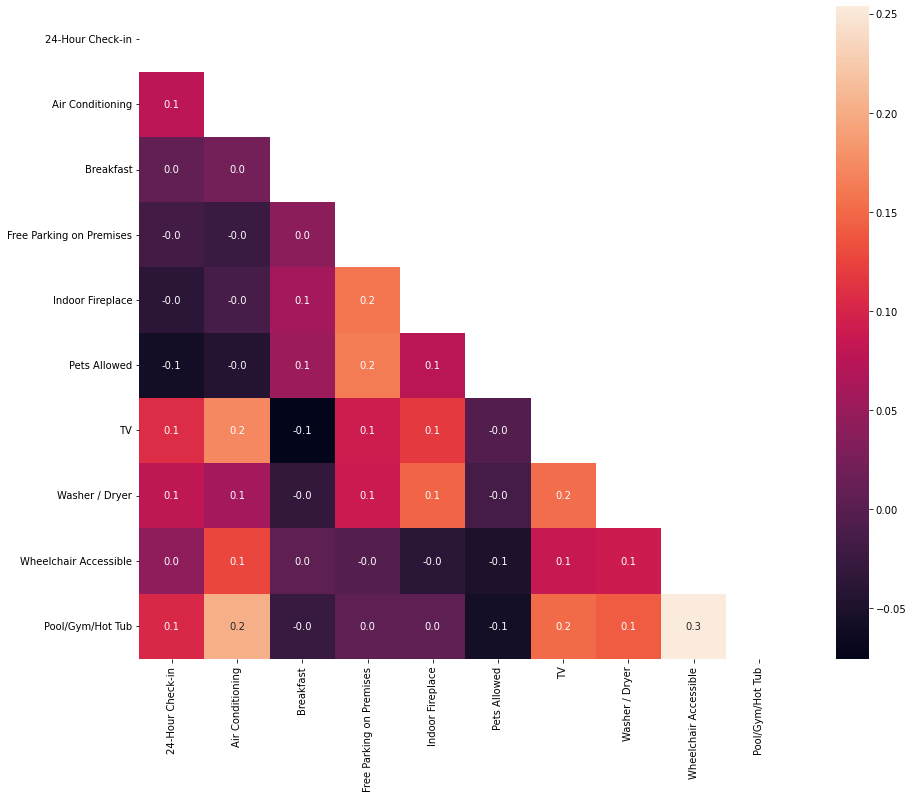

In [683]:
# heatmap
corrs = np.corrcoef(amns_df.values.T)
labels = amns_df.columns.str.replace("amns_", "")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrs, dtype=bool))

fig = plt.subplots(figsize=(16, 12))
sns.heatmap(corrs, mask=mask, cbar = True, annot=True, square = True, fmt = '.1f',
              yticklabels = labels, xticklabels = labels)

Now we have a small set of feature that we can add to our listing dataframe and enhance our model. We can also see that all variables have a low correlation which will help the overall perfomance of our model.

In [684]:
# add amenities to listings
listings = listings.join(amns_df)
listings.drop("amenities", axis=1, inplace=True)

# merge lisitngs & calender dataframe
df = pd.merge(listings, calendar, how='left', left_on='id', right_on='listing_id')

df = df.drop(['price_x', 'listing_id' ], axis=1)
df = df.rename({'price_y': 'price'}, axis=1)

# Drop any remaining rows without price information
df.dropna(subset=['price'], inplace=True)

In [685]:
df

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_group_cleansed,state,property_type,room_type,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month,host_since_days,is_local_host,24-Hour Check-in,Air Conditioning,Breakfast,Free Parking on Premises,Indoor Fireplace,Pets Allowed,TV,Washer / Dryer,Wheelchair Accessible,Pool/Gym/Hot Tub,price,month
0,241032,3,96.0,100.0,False,Queen Anne,WA,Apartment,Entire home/apt,4,1.0,1.0,1.0,207,10.0,False,moderate,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0
1,241032,3,96.0,100.0,False,Queen Anne,WA,Apartment,Entire home/apt,4,1.0,1.0,1.0,207,10.0,False,moderate,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0
2,241032,3,96.0,100.0,False,Queen Anne,WA,Apartment,Entire home/apt,4,1.0,1.0,1.0,207,10.0,False,moderate,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0
3,241032,3,96.0,100.0,False,Queen Anne,WA,Apartment,Entire home/apt,4,1.0,1.0,1.0,207,10.0,False,moderate,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0
4,241032,3,96.0,100.0,False,Queen Anne,WA,Apartment,Entire home/apt,4,1.0,1.0,1.0,207,10.0,False,moderate,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795241,8902327,4,100.0,100.0,False,Capitol Hill,WA,Apartment,Entire home/apt,4,1.0,1.0,2.0,2,10.0,False,moderate,1,2.00,2529.0,1,1,0,0,1,0,0,1,0,0,0,79.0,12.0
795242,8902327,4,100.0,100.0,False,Capitol Hill,WA,Apartment,Entire home/apt,4,1.0,1.0,2.0,2,10.0,False,moderate,1,2.00,2529.0,1,1,0,0,1,0,0,1,0,0,0,125.0,12.0
795243,8902327,4,100.0,100.0,False,Capitol Hill,WA,Apartment,Entire home/apt,4,1.0,1.0,2.0,2,10.0,False,moderate,1,2.00,2529.0,1,1,0,0,1,0,0,1,0,0,0,125.0,12.0
795244,8902327,4,100.0,100.0,False,Capitol Hill,WA,Apartment,Entire home/apt,4,1.0,1.0,2.0,2,10.0,False,moderate,1,2.00,2529.0,1,1,0,0,1,0,0,1,0,0,0,79.0,1.0


Text(0, 0.5, '')

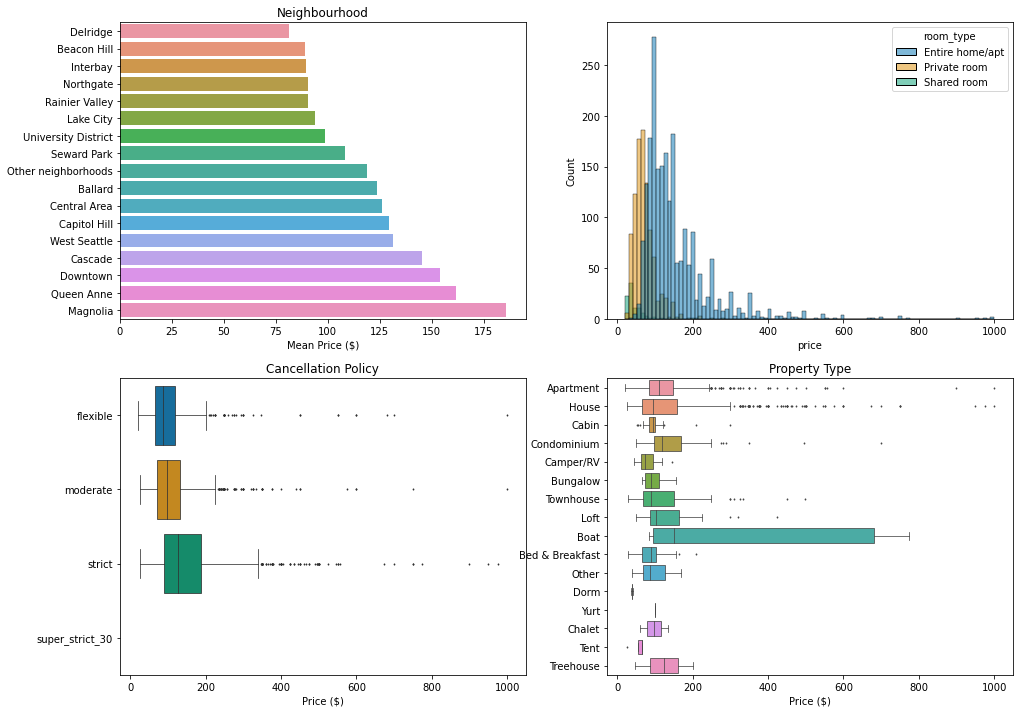

In [686]:
# Neighbourhoods
neighbourhoods = listings.groupby('neighbourhood_group_cleansed').agg(
    {
        'price': np.mean
    }
).reset_index().sort_values('price')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

sns.barplot(
    x='price', y='neighbourhood_group_cleansed',
    data=neighbourhoods.sort_values('price'),
    orient='h',
    ax=axs[0, 0]
)
axs[0, 0].set_title('Neighbourhood')
axs[0, 0].set_xlabel('Mean Price ($)')
axs[0, 0].set_ylabel('')

# Room type
sns.histplot(x='price', hue='room_type', data=listings, ax=axs[0, 1])

# Cancellation Policy
sns.boxplot(x='price', y='cancellation_policy', fliersize=1, linewidth=0.75,
            data=listings, ax=axs[1, 0],
            order=['flexible', 'moderate', 'strict', 'super_strict_30'])
# axs[1, 0].set_xlim(0, 600)
axs[1, 0].set_title('Cancellation Policy')
axs[1, 0].set_xlabel('Price ($)')
axs[1, 0].set_ylabel('')

# Property type
sns.boxplot(x='price', y='property_type', fliersize=1, linewidth=0.75,
            data=listings, ax=axs[1, 1])
# axs[1, 1].set_xlim(0, 600)
axs[1, 1].set_title('Property Type')
axs[1, 1].set_xlabel('Price ($)')
axs[1, 1].set_ylabel('')

Text(0, 0.5, '')

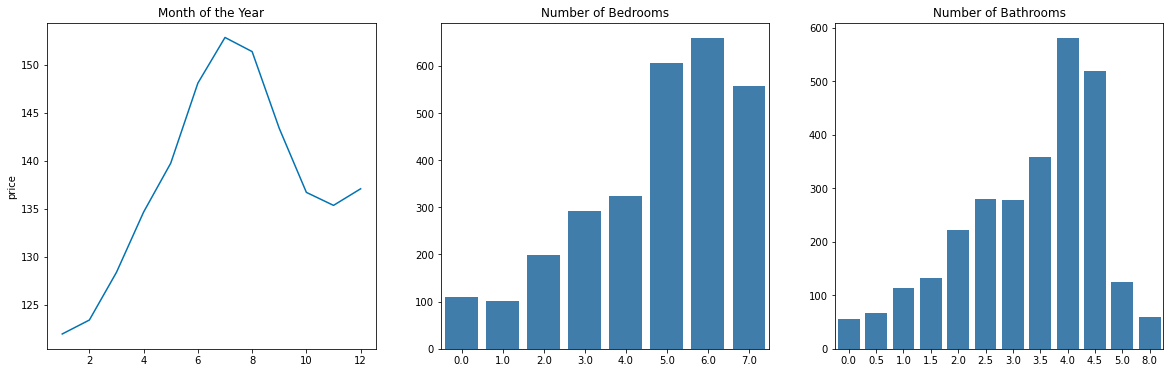

In [687]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Month plot
months = df.groupby('month').agg({'price': 'mean'}).reset_index()

sns.lineplot(
    x='month', y='price',
    data=months,
    ax=axs[0]
)
axs[0].set_title('Month of the Year')
axs[0].set_xlabel('')

# Bedrooms
bedrooms = df.groupby('bedrooms').agg({'price': 'mean'}).reset_index()
sns.barplot(
    x='bedrooms', y='price',
    data=bedrooms,
    orient='v',
    color='#2F7FBC',
    ax=axs[1]
)
axs[1].set_title('Number of Bedrooms')
axs[1].set_xlabel('')
axs[1].set_ylabel('')

# Bathrooms
bathrooms = df.groupby('bathrooms').agg({'price': 'mean'}).reset_index()
sns.barplot(
    x='bathrooms', y='price',
    data=bathrooms,
    orient='v',
    color='#2F7FBC',
    ax=axs[2]
)
axs[2].set_title('Number of Bathrooms')
axs[2].set_xlabel('')
axs[2].set_ylabel('')

There's a particularly strong relationship here between price and the number of bedrooms as well as bathrooms. However, with prices maxing out at 6 bedrooms & 4 bathrooms respectively, the relations seems to be non-linear. The month plot is on quite a narrow scale suggesting that it's impact is not so great.

In [688]:
# Dropping the extremely small subset of rows with no property_type
df = df.dropna(subset=['property_type']).copy()

# Imputing the mean for the remaining columns with null values
columns_with_null = df.columns[df.isnull().any()]
for column in columns_with_null:
    df[column] = df[column].fillna(df[column].median())

In [689]:
# create dummy columns
df = pd.get_dummies(df)
df = df.drop(['id'], axis=1)

In [690]:
df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,host_since_days,is_local_host,24-Hour Check-in,Air Conditioning,Breakfast,Free Parking on Premises,Indoor Fireplace,Pets Allowed,TV,Washer / Dryer,Wheelchair Accessible,Pool/Gym/Hot Tub,price,month,neighbourhood_group_cleansed_Ballard,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,state_WA,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,3,96.0,100.0,False,4,1.0,1.0,1.0,207,10.0,False,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,3,96.0,100.0,False,4,1.0,1.0,1.0,207,10.0,False,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,96.0,100.0,False,4,1.0,1.0,1.0,207,10.0,False,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,3,96.0,100.0,False,4,1.0,1.0,1.0,207,10.0,False,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,3,96.0,100.0,False,4,1.0,1.0,1.0,207,10.0,False,2,4.07,1004.0,1,0,1,0,0,0,0,1,1,0,0,85.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [691]:
def print_scores(model):
    """Print the R-squared and RMSE scores for the train and test set
    
    Parameters
        model: fitted regression model
    """
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
    rmse_test = (mean_squared_error(y_test, y_pred_test))**0.5

    print(
        'Train R-squared: {:.3f}\tTrain RMSE: ${:.2f}\
        \nTest R-squared: {:.3f}\tTest RMSE: ${:.2f}'
        .format(r2_train, rmse_train, r2_test, rmse_test)
    )

In [692]:
#Split into explanatory and response variables
X = df.drop('price', axis=1)
y = df.price

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

print_scores(lm_model)

Train R-squared: 0.630	Train RMSE: $64.94        
Test R-squared: 0.629	Test RMSE: $64.57


These results look promising. The model is able to explain about 63% of variance in our test dataset. However the RSME error of our predictions would be around 65$ which is a wide range considering the asked rates per night. Let's see what feature actually make the biggest impact on the price of a listing.

In [693]:
def validate_feat_importance(X, lm_model):

    feature_importance = pd.DataFrame(
        {'features': X.columns, 'coefficients': lm_model.coef_}
    ).sort_values(by='coefficients')
    feature_importance['features'] = feature_importance['features']

    fig = px.bar(x='features', y='coefficients',
                data_frame=feature_importance, height=600)
    fig.show();

In [694]:
validate_feat_importance(X, lm_model)

This chart is showing us the importance of our features. We can see that some amenities like TV or Washer/Dryer of a listing are basically irrelevant compared to the other factors like being situated in Downtown Seattle or the property_type "Boat".

In [695]:
rf = RandomForestRegressor(n_estimators=25, n_jobs=-1)
rf.fit(X_train, y_train)
print_scores(rf)

Train R-squared: 0.982	Train RMSE: $14.15        
Test R-squared: 0.980	Test RMSE: $14.84


In [696]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
print_scores(xgb)

Train R-squared: 0.955	Train RMSE: $22.59        
Test R-squared: 0.954	Test RMSE: $22.67
